# Consumption and Generation Reference System

This tutorial is about the effect of the sign of active and reactive power in load and sgen in pandapower. In this tutorial, the load element is used to model power consumption and the static generator element is used to model power generation. In pandapower, the convention for consumption and generation is different. This difference between consumer frame convention and generator frame convention will be demonstrated here.

![](l.png)

In regard to reactive power, there are 2 states for the 4 quadrants of each frame convention: under-excited and over-excited.

In the Consumer Frame Convention, which is used for load-like elements (load, shunt, ward, xward, storage), the term ‘under-excited’ is used to indicate that the load is in I and II quadrants and is absorbing reactive power (decreases voltage) and the term ‘over-excited’ is used to indicate that the load is in the III and IV quadrants and is injecting reactive power (increases voltage).

In the Generator Frame Convention, which is used for generator-like elements (gen, sgen, ext_grid), the term ‘over-excited’ is used to indicate the generator is in the I and II quadrants and is injecting reactive power (increases voltage), and the term ‘under-excited’ is used to indicate the generator is in III and IV quadrants and is absorbing reactive power (decreases voltage).

We show the differences between the reference systems with the following example.

In [1]:
import pandapower as pp
import pandas as pd
import numpy as np
import seaborn as sn

In [2]:
net=pp.create_empty_network()
bus0 = pp.create_bus(net, name="Bus 0", vn_kv=110, type="b")
bus1 = pp.create_bus(net, name="Bus 1", vn_kv=110, type="b")
line0 = pp.create_line(net, bus0, bus1, length_km=50, std_type="70-AL1/11-ST1A 110.0",  name="Line 1")
pp.create_sgen(net, bus1, p_mw=0, q_mvar=0, name="static generator")
pp.create_ext_grid(net, bus0, vm_pu=1.02, va_degree=50)
pp.create_load(net, bus1, p_mw=0, q_mvar=0, name="load i")
net

This pandapower network includes the following parameter tables:
   - bus (2 elements)
   - load (1 element)
   - sgen (1 element)
   - ext_grid (1 element)
   - line (1 element)

In [3]:
df=pd.DataFrame(columns=['element', 'p_mw', 'q_mvar', 'vm_pu', 'p_from_mw', 'p_to_mw'])

We will take three variations of p_mw (0, 50, -50) and three variations of q_mvar (0, 25, -25) for both load and sgen to analyze the output of the voltages.

In [4]:
i=0
for element in ('load', 'sgen'):
    for x in [0, 50, -50]:
        for y in [0, 25, -25]:
            net[element].loc[0,['p_mw', 'q_mvar']] = x, y
            pp.runpp(net)
            df.loc[i, 'element'] = element
            df.loc[i, ['p_mw', 'q_mvar']] = x,y
            df.loc[i, 'vm_pu'] = net.res_bus.vm_pu.at[bus1]
            df.loc[i, 'p_from_mw'] = net.res_line.p_from_mw.at[line0]
            df.loc[i, 'p_to_mw'] = net.res_line.p_to_mw.at[line0]
            i += 1
    net[element].loc[0, ['p_mw', 'q_mvar']] = 0, 0

In [5]:
df

,element,p_mw,q_mvar,vm_pu,p_from_mw,p_to_mw
0,load,0,0,1.021515,0.001135,0.0
1,load,0,25,0.972767,1.060615,-0.0
2,load,0,-25,1.064408,1.011292,-0.0
3,load,50,0,0.923861,55.002097,-50.0
4,load,50,25,0.867587,57.021399,-50.0
5,load,50,-25,0.971638,55.720967,-50.0
6,load,-50,0,1.096104,-46.445807,50.0
7,load,-50,25,1.050547,-45.232313,50.0
8,load,-50,-25,1.136787,-45.80152,50.0
9,sgen,0,0,1.021515,0.001135,0.0


If you look at the 4th index, you will see both the active and reactive power of the load are positive and the voltage has been reduced. This is a result of consumption of P and Q in the under excited state. In the 5th index the active power is positive but the reactive power is negative and as the result, the voltage does not drop as much as in the case of index 4.

Now we will see the plots for both the elements where the reference systems can be compared and the vm_pu values are shown for different combinations of active and reactive power.

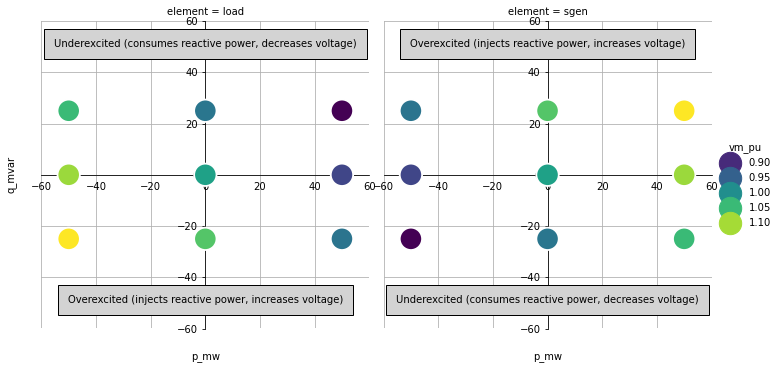

In [6]:
import matplotlib.pyplot as plt
g=sn.relplot(x="p_mw", 
        y="q_mvar",
        size="vm_pu",
        col="element",
        sizes=(500,500),
        palette="viridis",
        hue="vm_pu",
        data=df, alpha=1, zorder=10)
g.set(xlim=(-60,60),ylim=(-60,60))

texts =[['Underexcited (consumes reactive power, decreases voltage)', 'Overexcited (injects reactive power, increases voltage)'],
        ['Overexcited (injects reactive power, increases voltage)', 'Underexcited (consumes reactive power, decreases voltage)']]

for ax, text in zip(g.axes[0], texts):
    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.labelpad = 160
    ax.yaxis.labelpad = 160
    ax.grid()
    ax.text(0,50, text[0], bbox={'facecolor': 'lightgrey', 'pad': 10}, horizontalalignment='center', zorder=10)
    ax.text(0,-50, text[1], bbox={'facecolor': 'lightgrey', 'pad': 10}, horizontalalignment='center', zorder=10)

   
    

Notice that, in the plot for the load element, when the sign of reactive power is negative, the reactive power is injected, which increases voltage. And when the reactive power is positive, the voltage drops because the reactive power is absorbed. The opposite effect can be seen for sgen elements.